# Abstract

We study a variation of the Homicidal Chauffeur Problem in 2D, a differential game where a prey is chased by a predator. In the general setting, the prey is more agile while the predator is faster: we interpret it as giving the prey higher acceleration, while the predator has greater maximum speed. We first study the interactions for a naive strategy pair: the prey evades through right angle acceleration, while the predator directly accelerates towards the prey's current position. We observe metrics relevant to specific trajectories and use fourier analysis to study the natural frequencies of relevant metrics in time. We then consider a more sophisticated pursuit-evasion strategy, characterizing how acceleration and velocity affect the 'bound' between prey and predator.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import clear_output
import time
import math
from numba import njit
import scipy

# General Setting
We first consider a simple model for behavior of both predator and prey. For the sake of understanding, we will initialize the simulation with prey at maximum velocity, pointing at different angles (bearings), and predator at rest. 

With the initial conditions being the following:

$\left\{
\begin{aligned}
    x(0) &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\
    y(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{aligned}
\right.
\hspace{3em}
\left\{
\begin{aligned}
    \dot{x}(0) &= 
    \begin{bmatrix}
        \cos\theta & -\sin\theta \\
        \sin\theta & \cos\theta
    \end{bmatrix}
    \begin{pmatrix}
        v^x_{\text{max}} \\
        0
    \end{pmatrix} \\
    \dot{y}(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{aligned}
\right.$


$\left\{
\begin{aligned}
    \ddot{x}(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix} \\
    \ddot{y}(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{aligned}
\right.$

In [2]:
@njit
def get_trajectory(deg: float, n_steps: int, prey_speed_max: float, pred_speed_max: float):
    """
    Initialize a trajectory state array for a 2D predator-prey simulation.

    The state array has shape (n_steps, 2 agents, 3 features, 2 dimensions), where:
    - time: t in {0, ..., n_steps - 1}
    - agents: 0 = predator, 1 = prey
    - features: 0 = position, 1 = velocity, 2 = acceleration
    - dimensions: 2D (x, y)

    Args:
        deg (float): Direction angle (in degrees) of prey's initial velocity.
        params (dict): Dictionary containing simulation parameters including 'n_steps' and '11_max' (prey's max speed).

    Returns:
        np.ndarray: Initialized state array.
    """
    
    state = np.zeros((n_steps, 2, 3, 2), dtype=float)

    # initial predator pos, vel, acc
    state[0, 0, 0] = [0, 0] 
    state[0, 0, 1] = [pred_speed_max, 0] 
    state[0, 0, 2] = [0, 0] 

    rad = np.deg2rad(deg) 

    # initial prey pos, vel, acc
    state[0, 1, 0] = [10, 0]
    state[0, 1, 1] = [np.sin(rad) * prey_speed_max, np.cos(rad) * prey_speed_max]
    state[0, 1, 2] = [0, 0] 
    
    return state

As a data object, we use a 'state' numpy tensor to precompute the trajectory, before plotting it in its entirety.

## Toy Setting
We first consider a toy setting with the following behaviour.
- Predator accelerates in a straight line towards the prey, constantly updating the acceleration vector.
- The prey preserves acceleration, only changing it.
- Predator has higher acceleration than the prey.
- Prey has a higher top speed than the prey.

Written more formally, one considers the trajectory tuple $(x,y)(t)\in \mathbb{R}^2 \times \mathbb{R}^2$:

$\left\{
\begin{aligned}
    \ddot{x}(t) &= 
    \begin{cases}
        a^{\text{max}}_x
        \begin{bmatrix}
            0 & -1 \\
            1 & 0
        \end{bmatrix}
        \dfrac{y(t) - x(t)}{\|y(t) - x(t)\|} 
        & \|x(t) - y(t)\| < R_{\text{react}} \\[1.2em]
        \ddot{x}(t^*_{\text{last react}}) 
        & \|x(t) - y(t)\| \geq R_{\text{react}}
    \end{cases} \\
    \ddot{y}(t) &= a^{\text{max}}_{y} \cdot \frac{x(t) - y(t)}{\|x(t) - y(t)\|}
\end{aligned}
\right.$

The constraints of the directions are written in the following way:

$\left\{
\begin{aligned}
    v^{\text{max}}_x \leq v^{\text{max}}_y \\
    a^{\text{max}}_x \geq a^{\text{max}}_y
\end{aligned}
\right.$

In [3]:
@njit
def norm(v):
    return np.sqrt(np.sum(v ** 2))

@njit
def norm_list(v):
    out = np.empty(v.shape[0])
    for i in range(v.shape[0]):
        out[i] = np.sqrt(v[i, 0] ** 2 + v[i, 1] ** 2)
    return out

@njit
def normalize(v):
    length = norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

@njit
def rotate_right_90(v):
    """Rotate a 2D vector 90 degrees to the right (clockwise)."""
    return np.array([v[1], -v[0]])

@njit
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

We use Euler Integration despite its O(n^2) error rate, as it is easily computable and simple to implement.

In [4]:
@njit
def step(state, t, dt, pred_speed_max, prey_speed_max):
    """
    Update position and velocity for timestep t based on previous state.
    Applies max speed limits separately for predator (agent 0) and prey (agent 1).
    """
    # Position update
    state[t, :, 0, :] = state[t-1, :, 0, :] + state[t-1, :, 1, :] * dt

    # Velocity update
    state[t, :, 1, :] = state[t-1, :, 1, :] + state[t-1, :, 2, :] * dt

    # Limit predator speed
    pred_speed = norm(state[t, 0, 1, :])
    if pred_speed > pred_speed_max:
        state[t, 0, 1, :] = state[t, 0, 1, :] / pred_speed * pred_speed_max

    # Limit prey speed
    prey_speed = norm(state[t, 1, 1, :])
    if prey_speed > prey_speed_max:
        state[t, 1, 1, :] = state[t, 1, 1, :] / prey_speed * prey_speed_max

    return state

## Proportional Navigation (PN)

The proportional navigation algorithm is used as a guidance law for tactical homing missiles. It aims to generate lateral acceleration for the missile proportional to the line of sight (LOS) angular rate, so that the missile velocity vector rotates in such a way to assure the interception of the target.

In order to generate the lateral accelerations, the algorithm uses measurements of the LOS angular rate and computes the closing velocity between the missile and the target. In our case, the LOS vector is calculated by taking `prey_pos - pred_pos`, which can then be divded by the `distance` between the predator and prey to get the unit LOS vector. The closing velocity is found by taking the dot product of the `LOS_unit` and the relative velocity `v_rel`.

Proportional navigation can guarantee interception of a target moving with constant velocity. However, if the target is accelerating, there can be a nonzero miss distance "Missile Guidance using PN and ML"

In [5]:
@njit
def proportional_navigation_acceleration(pred_pos, pred_vel, prey_pos, prey_vel, navigation_gain, pred_max_acc):
    r_vec = prey_pos - pred_pos # line of sight (LOS)
    v_rel = prey_vel - pred_vel # relative velocity

    dist = norm(r_vec)
    
    # Normalized line of sight vector
    los_unit = r_vec / dist
    
    # Cross product to get line of sight rotation rate
    los_rate = cross2d(r_vec, v_rel) / (dist ** 2)

    # Rotate los unit
    los_perp = np.array([-los_unit[1], los_unit[0]])
    
    # Proportional navigation acceleration
    acc_mag = navigation_gain * los_rate * norm(v_rel)

    acceleration = acc_mag * los_perp
    
    return acceleration



To both leverage Python's abstraction and Jupyter's interactivity, while speeding code generation use the _numba_ package to enable Just-In-Time compilation, which speeds up computation of the trajectory by an order of 20-40x.

In [6]:
def simulate(state, params):
    if params["R_kill"] == -1:
        return simul_nokill(state, params["dt"], params["R_react"], params["pred_acc"], params["prey_acc"], params["pred_max_speed"], params["prey_max_speed"], params['navigation_gain'])
    return simul(state, params["dt"], params["R_kill"], params["R_react"], params["pred_acc"], params["prey_acc"], params["pred_max_speed"], params["prey_max_speed"], params['navigation_gain'])

@njit
def simul(state, dt, r_kill, r_react, acc_pred, acc_prey, pred_max_speed, prey_max_speed, navigation_gain):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    n_steps = state.shape[0]

    for t in range(1, n_steps):
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        distance = norm(direction)

        if distance < r_kill:
            return state, t            
        elif distance < r_react:
            # Prey reacts: rotate predator-prey vector 90° right
            state[t-1, 1, 2, :] = normalize(rotate_right_90(direction)) * acc_prey

        # Predator always steers toward prey
        state[t-1, 0, 2, :] = pred_acc_update(state, t, acc_pred, navigation_gain)

        # Step positions and velocities
        step(state, t, dt, pred_max_speed, prey_max_speed)

    return state, n_steps       

@njit
def simul_nokill(state, dt, r_react, acc_pred, acc_prey, pred_max_speed, prey_max_speed, navigation_gain):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    for t in range(1, state.shape[0]):
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        distance = norm(direction)

        if distance < r_react:
            # Prey reacts: rotate predator-prey vector 90° right
            state[t-1, 1, 2, :] = normalize(rotate_right_90(direction)) * acc_prey

        state[t-1, 0, 2, :] = pred_acc_update(state, t, acc_pred, navigation_gain)

        # Step positions and velocities
        step(state, t, dt, pred_max_speed, prey_max_speed)

    return state, len(state)       

@njit
def pred_acc_update(state, t, acc_pred, navigation_gain):
    # Predator always steers toward prey
    #return normalize(state[t-1, 1, 0, :] - state[t-1, 0, 0, :]) * acc_pred
    return proportional_navigation_acceleration(state[t-1, 0, 0, :], state[t-1, 0, 1, :], state[t-1, 1, 0, :], state[t-1, 1, 1, :], navigation_gain, acc_pred)

We consider some metrics that may be relevant to understanding a trajectory:
- _Signed Distance_: we model the distance between prey and predator by multiplying it with a sign representing whether the predator is left or right of the predator: we use the cross product to compute the sign, and extract the with an <u>activation</u> function.
- _Derivative of Distance_: the rest of change of 'absolute' distance is telling of how effective the predator is at reaching the prey, so we model it.
- _Dot product of Velocities_: the level of alignment of the prey and predator's velocity, giving to what extent they are moving parallel to each other.

In [7]:
def signed_distance(state, activation=lambda x: np.sign(x)):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]

    prey_vel = state[:, 1, 1, :]
    cross_z = prey_vel[:, 0] * distance[:, 1] - prey_vel[:, 1] * distance[:, 0]
    return norm_list(distance) * activation(cross_z)

@njit
def sign_distance(state):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]

    prey_vel = state[:, 1, 1, :]
    cross_z = prey_vel[:, 0] * distance[:, 1] - prey_vel[:, 1] * distance[:, 0]
    return norm_list(distance) * np.sign(cross_z)

@njit
def positive_distance(state):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]
    return norm_list(distance)

@njit
def numba_gradient(arr):
    # Calculate the gradient using forward and backward differences
    grad = np.zeros_like(arr)
    
    # Forward difference for the first element
    grad[0] = arr[1] - arr[0]
    
    # Backward difference for the last element
    grad[-1] = arr[-1] - arr[-2]
    
    # Central difference for the inner elements
    for i in range(1, len(arr) - 1):
        grad[i] = (arr[i + 1] - arr[i - 1]) * 0.5
    
    return grad

@njit
def distance_derivative(state):
    pred_pos = state[:, 0, 0, :]
    prey_pos = state[:, 1, 0, :]
    distance = norm_list(pred_pos - prey_pos)
    return numba_gradient(distance)

@njit
def velocity_dot_product(state):
    pred_vel = state[:, 0, 1, :]
    prey_vel = state[:, 1, 1, :]
    return np.sum(pred_vel * prey_vel, axis=1)

For compactness, we condense the following views into one picture: a local view (x and y axes equally), a global view (autoscaled axes) and different metrics.

Killed


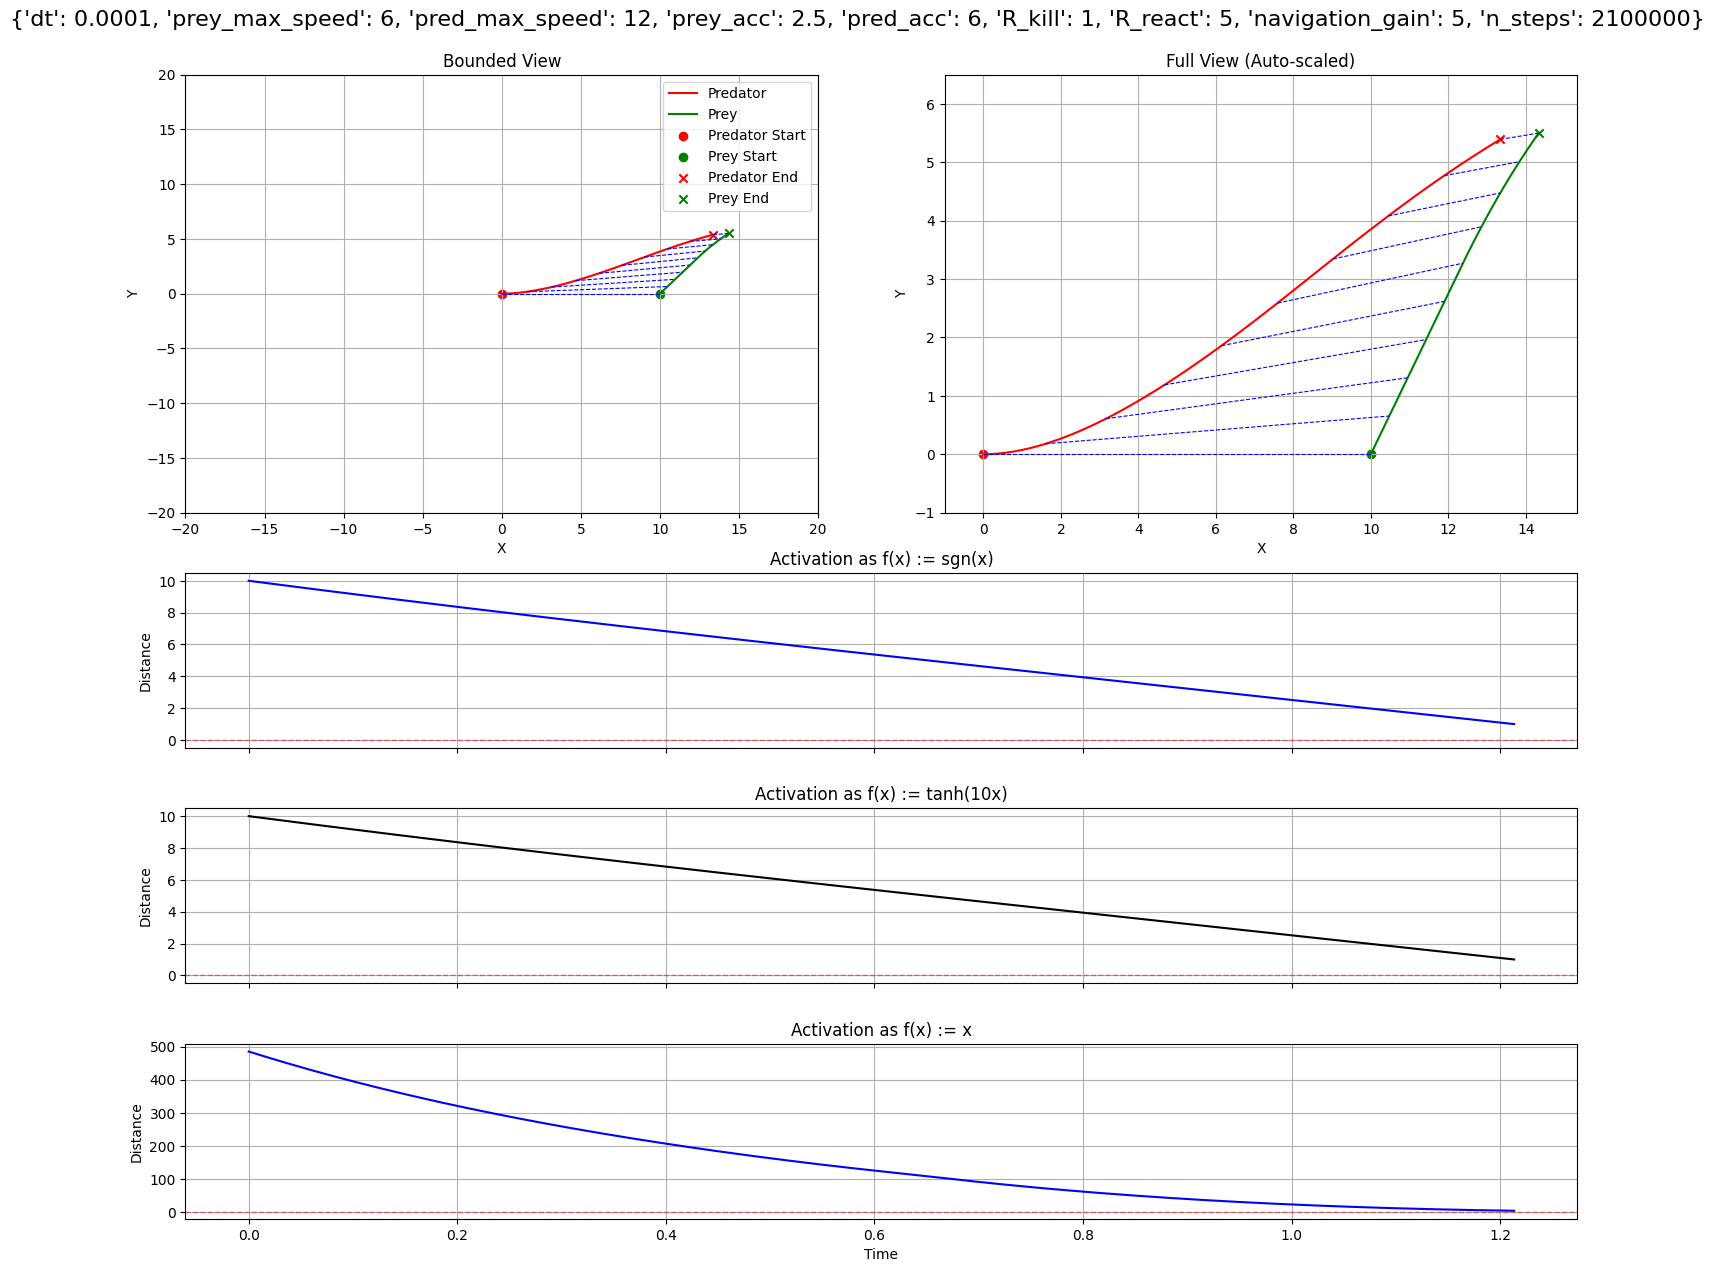

In [8]:
from utilities import plot_combined_analysis

sign = lambda state : signed_distance(state, activation = lambda x: np.sign(x))
tanh = lambda state : signed_distance(state, activation = lambda x: np.tanh(10*x))
id = lambda state : signed_distance(state, activation = lambda x: x)

params = {
    "dt": 0.0001,
    
    "prey_max_speed": 6,
    "pred_max_speed": 12, # >
    
    "prey_acc": 2.5, # >
    "pred_acc": 6,
    
    "R_kill": 1,
    "R_react": 5,

    "navigation_gain": 5,
}

distance = 210
bearing = 36
params['n_steps'] = round(distance / params['dt'])

state = get_trajectory(bearing, params['n_steps'], params['prey_max_speed'], params['pred_max_speed'])

state, length = simulate(state, params)
if len(state) != length:
    print('Killed')

state = state[:length]

plot_combined_analysis(
    state,
    params=params,
    analysis_fns=[
        (sign, 'Activation as f(x) := sgn(x)', 'Distance'),
        (tanh, 'Activation as f(x) := tanh(10x)', 'Distance'),
        (id, 'Activation as f(x) := x', 'Distance'),
    ],
)

We notice a clear tradeoff between the regularity of the 'Signed Distance Function' and its fidelity in representing both sign and distance, depending on the activation function.

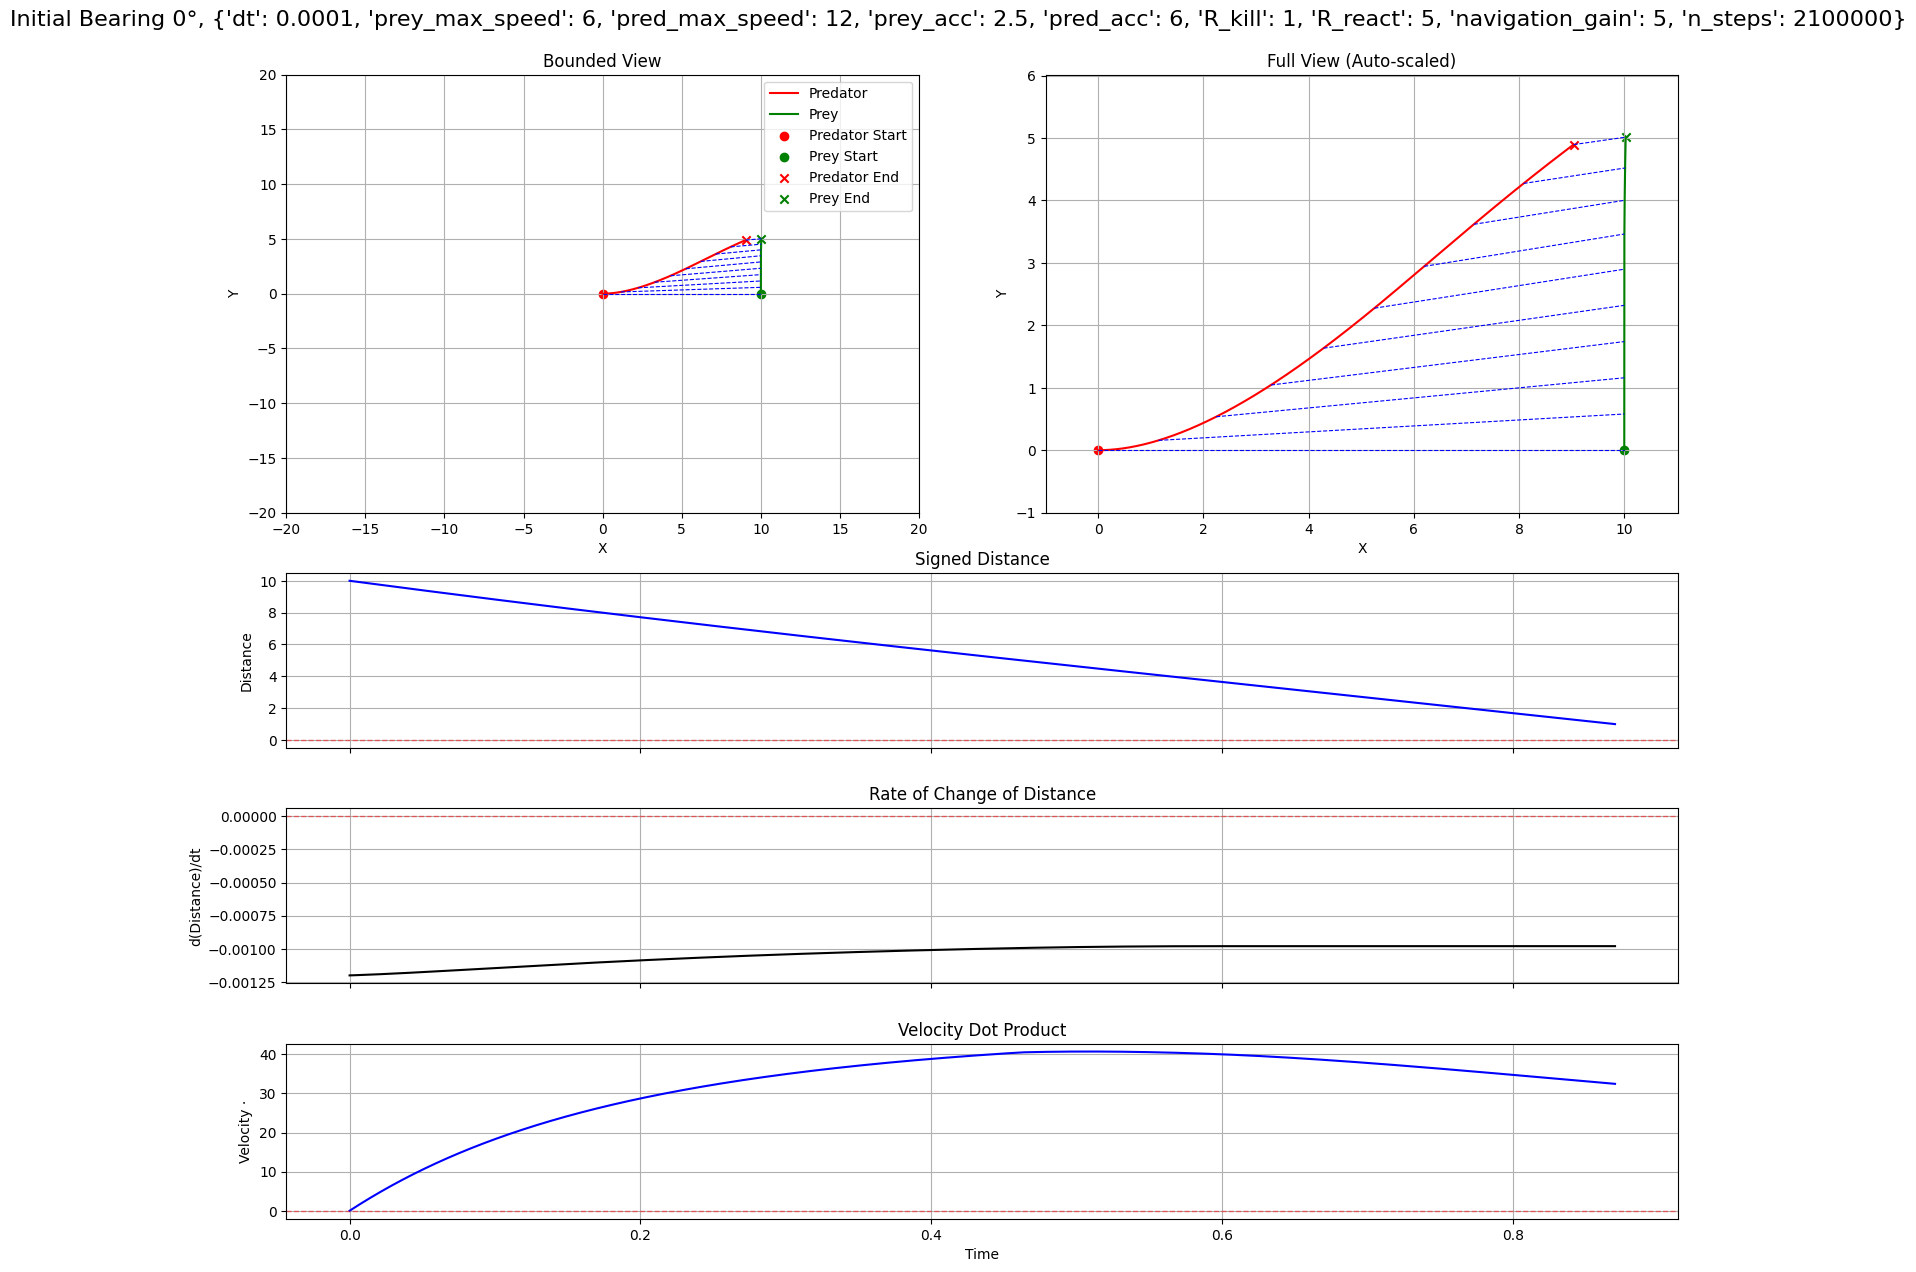

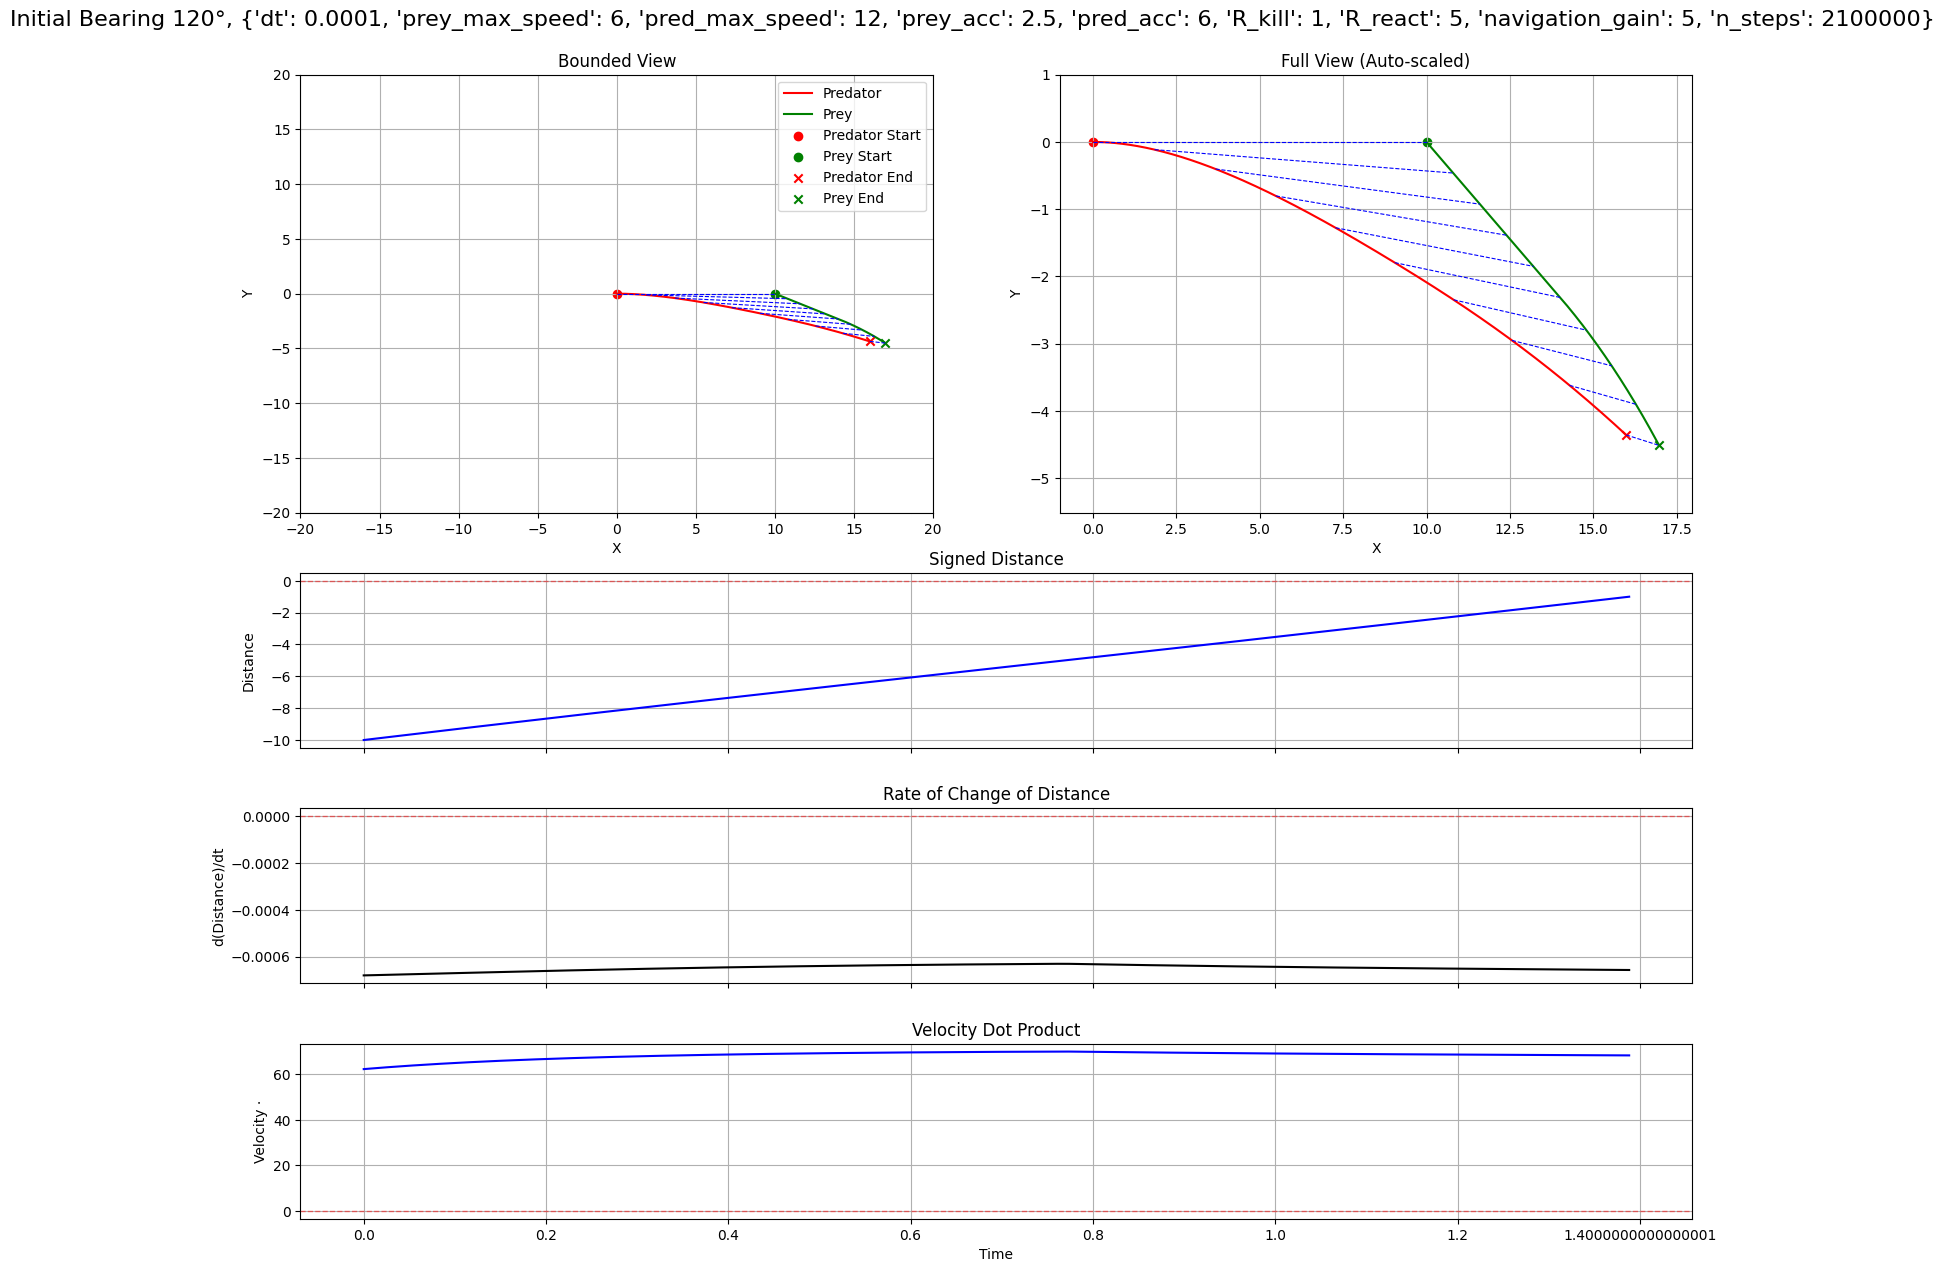

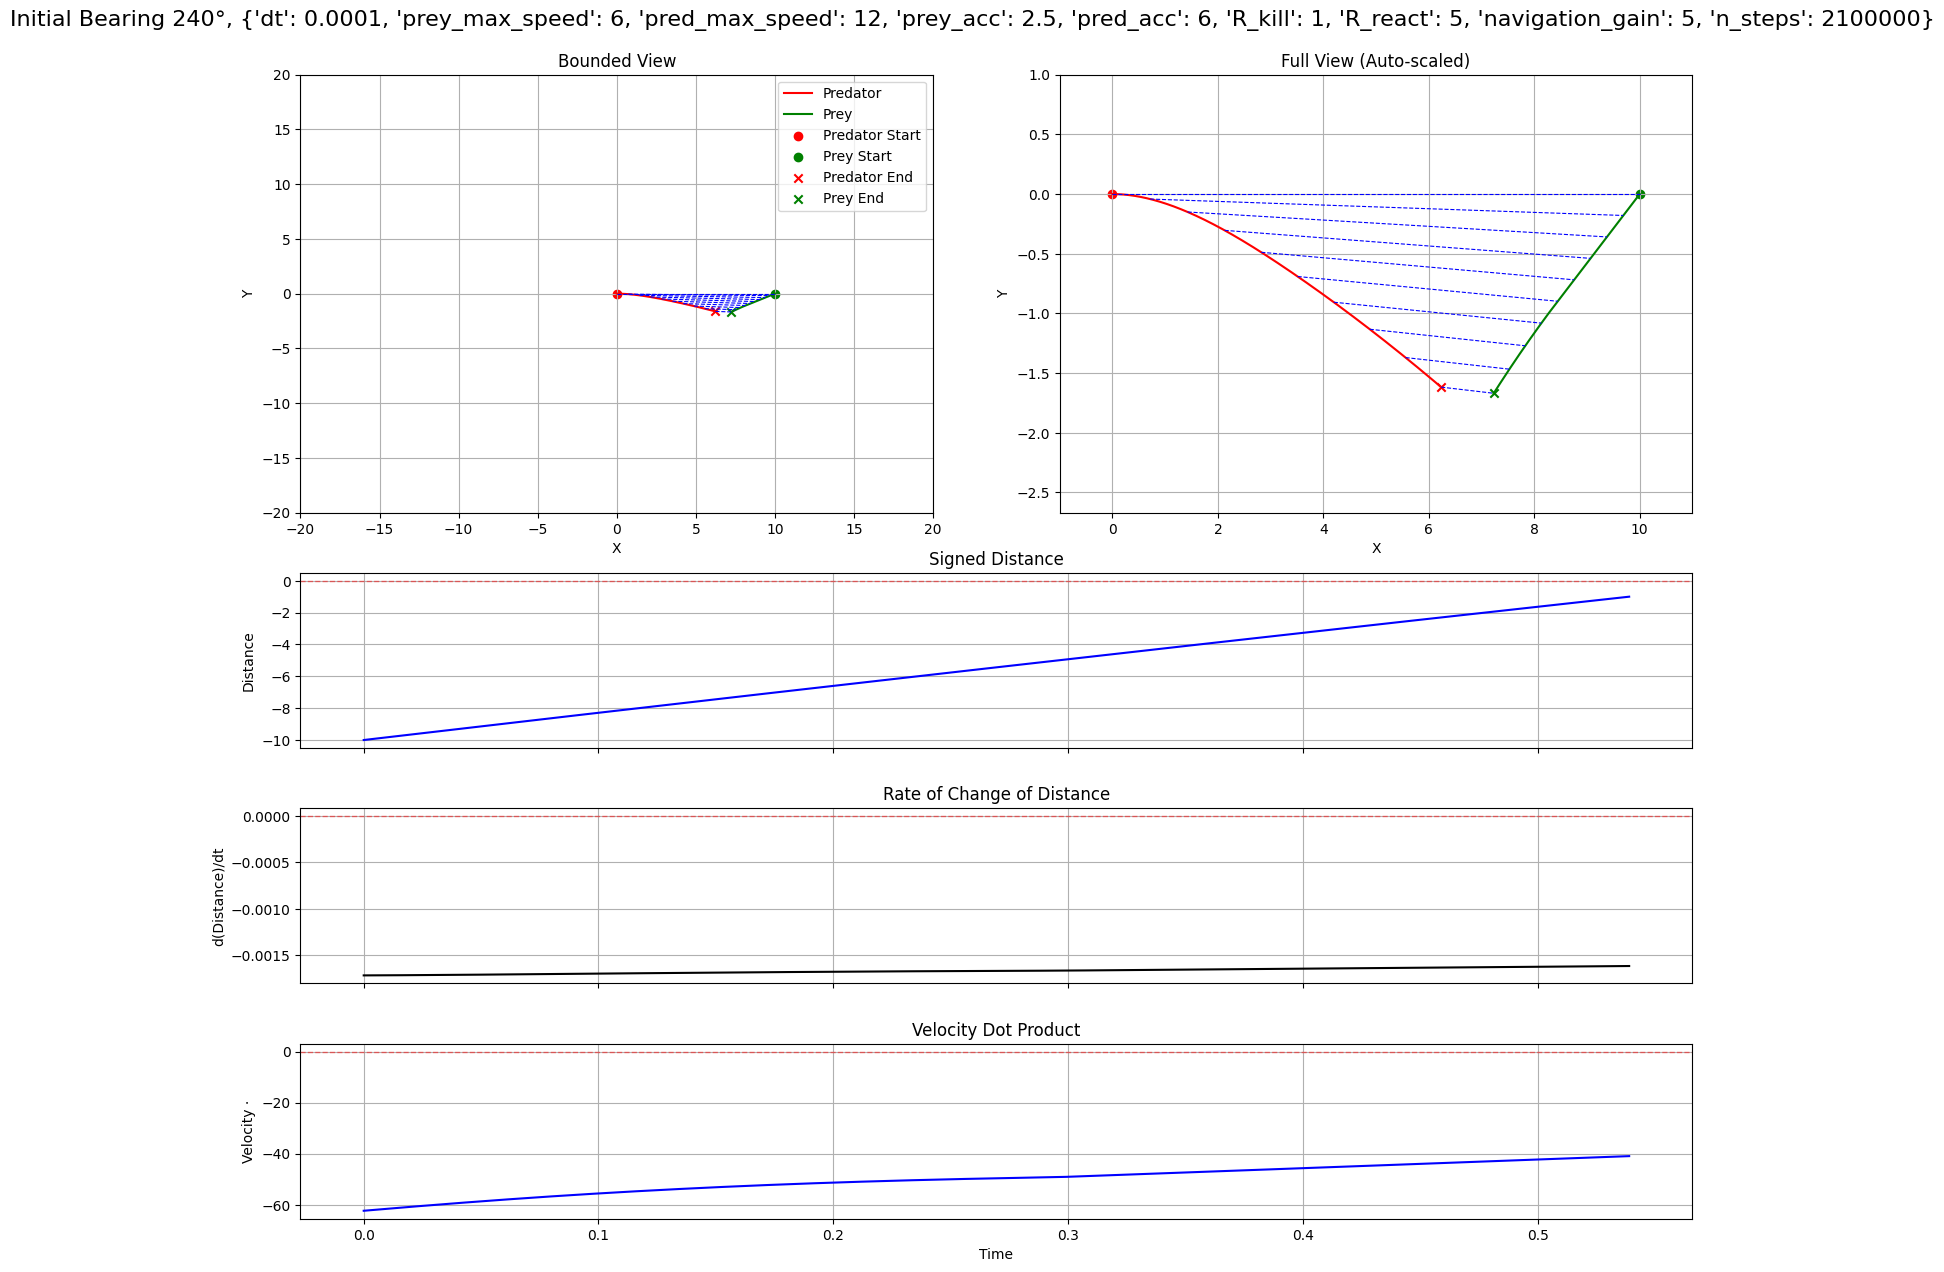

In [9]:
recordings = []
n = 3
distance = 210 # 

for i in range(n):
    bearing = 360/n*i
    params['n_steps'] = round(distance / params['dt'])
    
    state = get_trajectory(bearing, params['n_steps'], params['prey_max_speed'], params['pred_max_speed'])
    state, length = simulate(state, params)
    state = state[:length]
    recordings += [(params, state)]
    
    plot_combined_analysis(
        state,
        params=params,
        analysis_fns=[
            (signed_distance, 'Signed Distance', 'Distance'),
            (distance_derivative, 'Rate of Change of Distance', 'd(Distance)/dt'),
            (velocity_dot_product, 'Velocity Dot Product', 'Velocity ⋅')
        ],
        title = f'Initial Bearing {bearing:.0f}°, {params}'
    )

The presence of waves and a natural frequency suggests the need to use more advanced methods to understand the behavior, namely the Cosine Transform: this technique allows to extract the natural frequencies from a periodic function.

In [10]:
@njit
def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

@njit
def hamming_window(N):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

For the transform to be feasible, we use the Discrete Cosine Transform, which has an O(N*log(N)) time complexity. Moreover, as only a part of the wave is calculated, the cutoff is bound to be imprecise. For this reason we use a window function, picking the best. We first study the decomposition of the Signed Distance: 

In [11]:
@njit
def twiddle_factors(N):
    """Pre-compute twiddle factors for FFT"""
    factors = np.zeros(N//2, dtype=np.complex128)
    for k in range(N//2):
        angle = -2.0 * np.pi * k / N
        factors[k] = np.cos(angle) + 1j * np.sin(angle)
    return factors

@njit
def fft_radix2(x):
    """
    Numba-compatible FFT implementation using Radix-2 algorithm
    Only works for power-of-2 length inputs
    """
    N = len(x)
    
    # Base case for recursion
    if N == 1:
        return x
    
    # Check if N is a power of 2
    if N & (N-1) != 0:
        raise ValueError("Input length must be a power of 2")
    
    # Split into even and odd indices
    even = fft_radix2(x[0:N:2])
    odd = fft_radix2(x[1:N:2])
    
    # Combine results
    result = np.zeros(N, dtype=np.complex128)
    factors = twiddle_factors(N)
    
    for k in range(N//2):
        twiddle = factors[k] * odd[k]
        result[k] = even[k] + twiddle
        result[k + N//2] = even[k] - twiddle
    
    return result

@njit
def dct_via_fft(x):
    """
    DCT implementation using custom FFT function
    Only works for power-of-2 length inputs
    """
    N = len(x)
    
    # Prepare the input for FFT-based DCT
    y = np.zeros(2*N, dtype=np.complex128)
    for n in range(N):
        y[n] = x[n]
        y[2*N-1-n] = x[n]
    
    # Compute FFT
    Y = fft_radix2(y)
    
    # Apply scaling
    result = np.zeros(N)
    scale = np.sqrt(1.0 / (2.0 * N))
    for k in range(N):
        # Extract real part for DCT result
        result[k] = Y[k].real * scale
    
    # Additional scaling for DC component
    result[0] *= 1.0 / np.sqrt(2.0)
    
    return result

We plot the log-log Discrete Cosine Transform to study the results: decomposing the signed distance for the previous three trajectories, we notice that the _Hamming Window_ performs better, producing more 'peaked', which aligns more with the expected "Dirac Comb" shape for the transform. 

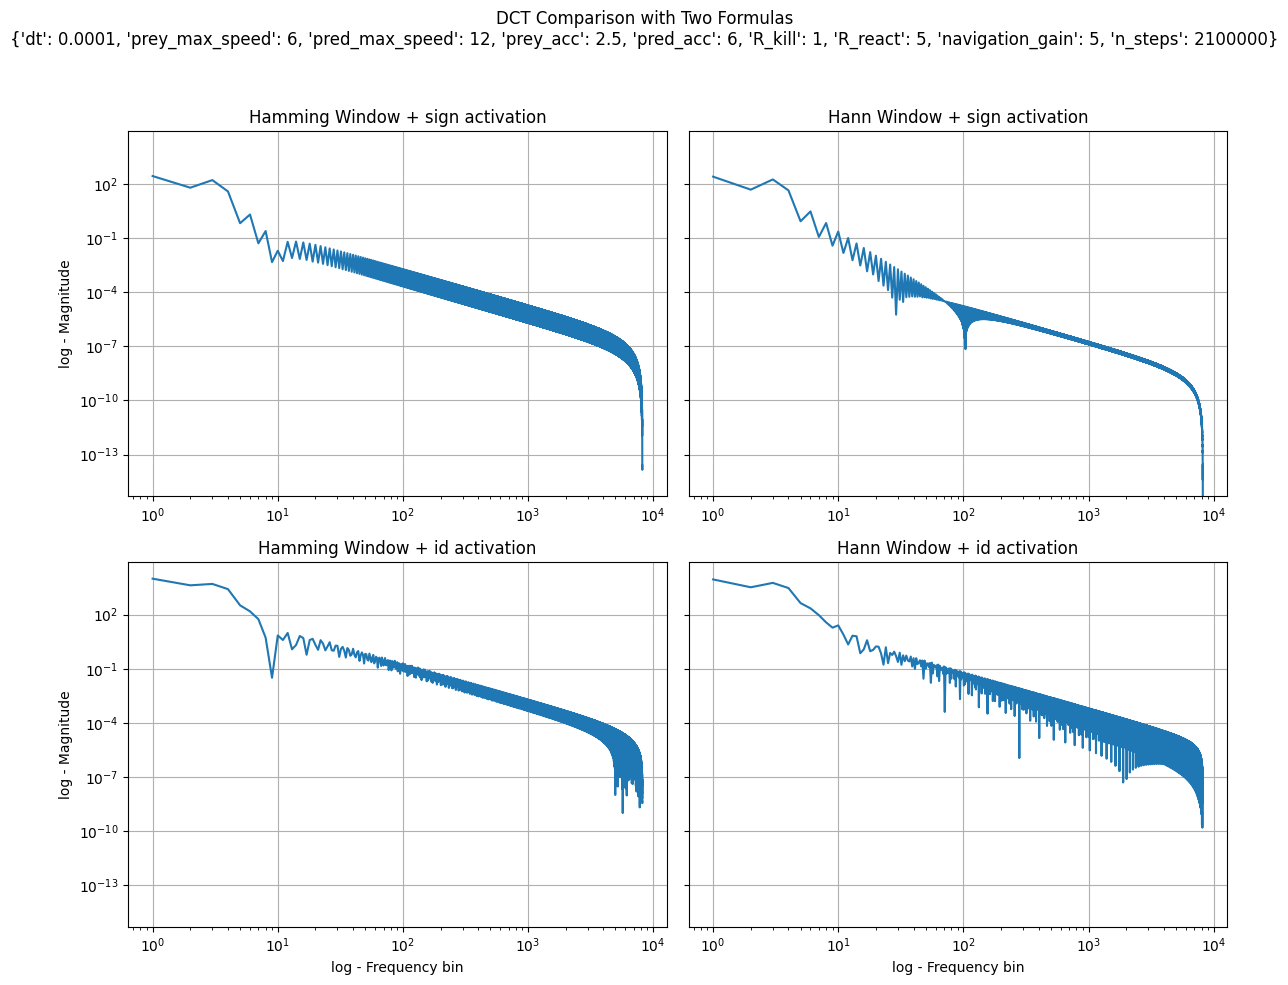

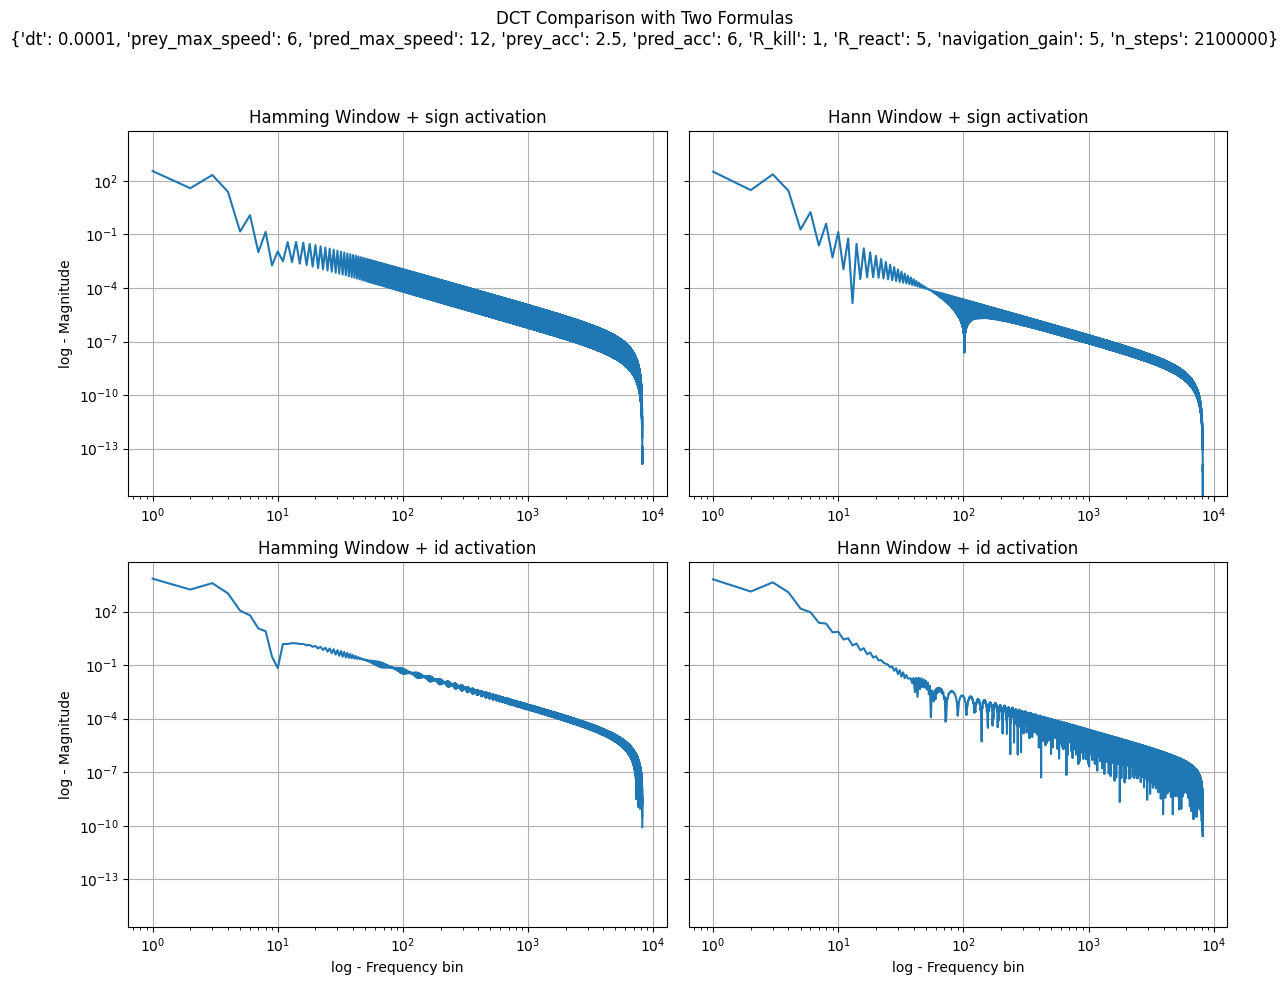

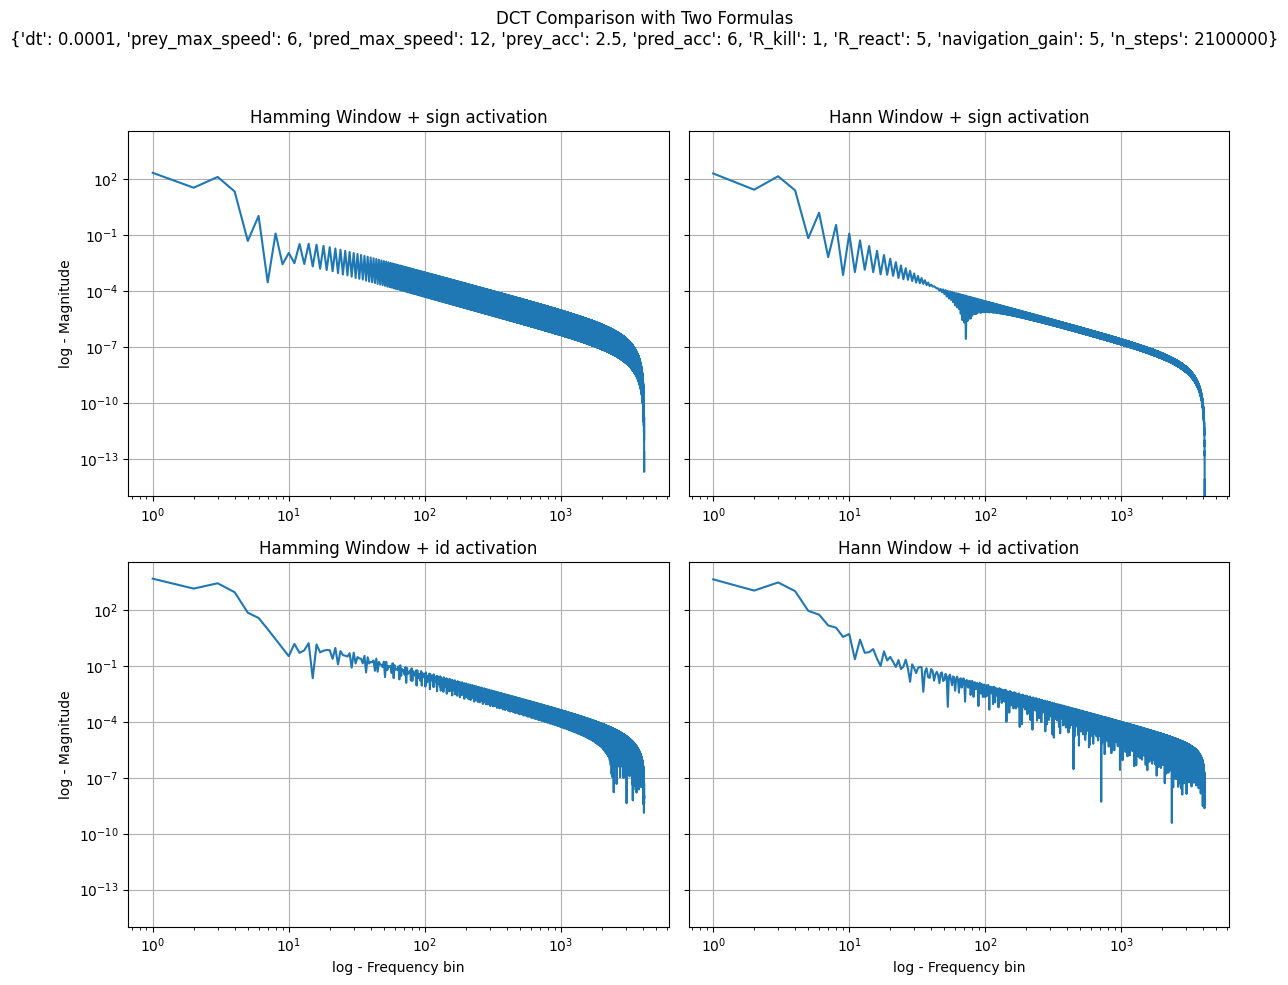

In [12]:
def dct(state, formula=signed_distance, window=hamming_window):
    """
    Computes the Discrete Cosine Transform (DCT) of a signal after applying a 
    windowing function and truncating the signal to the nearest power of two.

    Parameters:
    state (numpy.ndarray): Input signal array.

    Returns:
    numpy.ndarray: DCT of the windowed and truncated signal.
    """
    length = len(state)
    highest_two_power = 2**(length.bit_length() - 1)  # Get nearest power of two
    wave = formula(state)[:highest_two_power]
    return dct_via_fft(wave * window(len(wave)))

def compare_dct_windows(state, params: dict):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

    formulas = [(signed_distance, "sign activation"), (id, "id activation")]

    for row, (formula_fn, formula_name) in enumerate(formulas):
        for col, (window_fn, window_name) in enumerate(zip([hamming_window, hann_window], ['Hamming', 'Hann'])):
            result = dct(state, formula=formula_fn, window=window_fn)
            y = np.abs(result)
            x = np.arange(1, len(y) + 1)

            ax = axs[row, col]
            ax.plot(x, y, label=f'{window_name} window')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True)
            ax.set_title(f'{window_name} Window + {formula_name}')

            if row == 1:
                ax.set_xlabel('log - Frequency bin')
            if col == 0:
                ax.set_ylabel('log - Magnitude')

    fig.suptitle(f'DCT Comparison with Two Formulas\n{params}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

for params, state in recordings:
    compare_dct_windows(state, params)

We note three key characterizations of the waves, given their Cosine Transforms:
- <u>Mean Distance</u>: the y-axis intercept shows the mean value of the function.
- <u>Peak</u>: the Cosine Transform Identifies the key natural frequency of the way
- <u>Noisy tail</u>: the higher end of the transform are particularly noisy, especially for waves with jumps.

We also notice the presence of noise: in fact, when the signed distance uses the identity as activation, there is less noise and the decay rate - the slope of the right tail - is stronger (ie. the tail is steeper). As noise is related to the sinusoidality of the wave, it is clear that less stable waves produce more 'fuzzy' results.

After these observations, we switch to observing prey-predator distance, as it is a more regular metric of effectiveness, despite missing information on which 'side' of the prey is the predator.

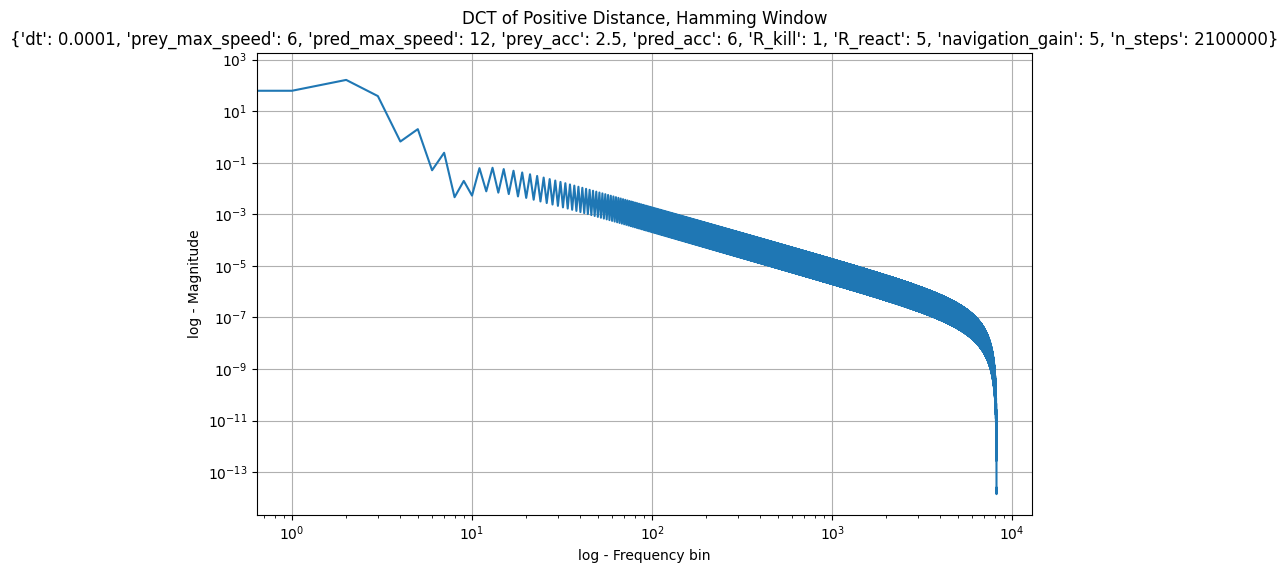

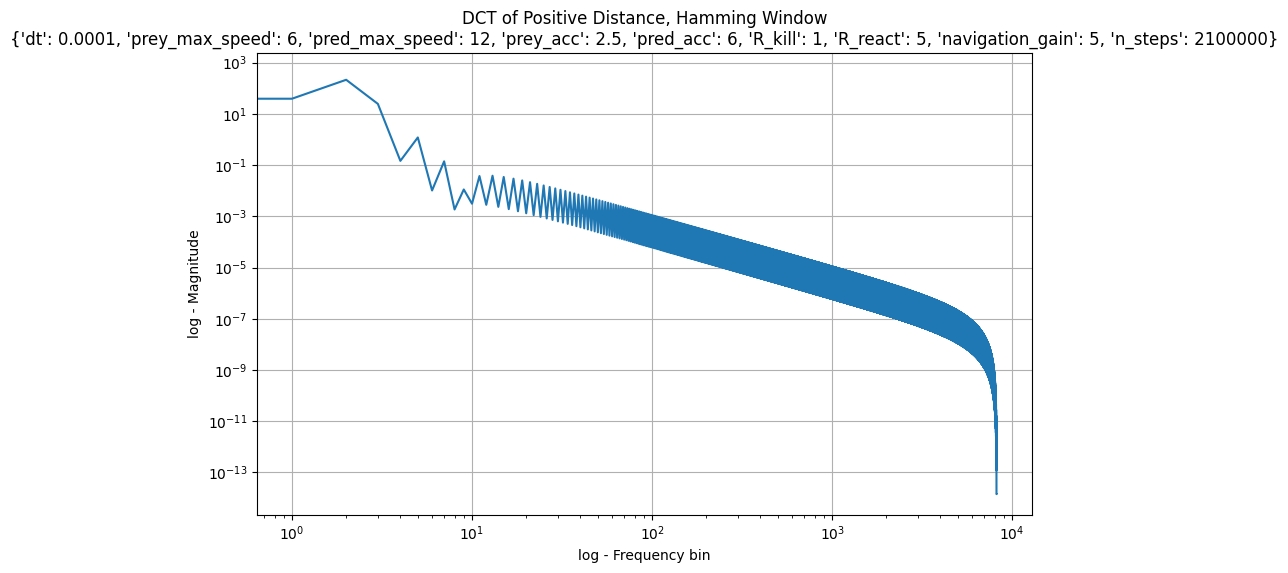

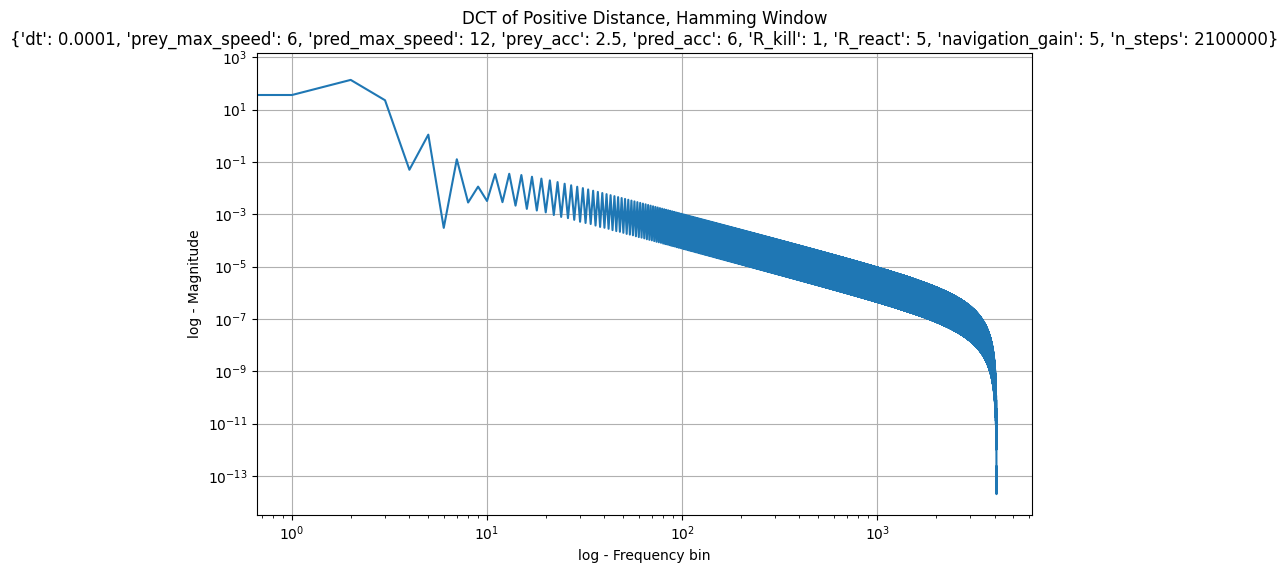

In [13]:
def plot_dct(dct_result, params: dict, title:str=""):
    if not title:
        title = f'DCT of State\n{params}'

    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(dct_result), label='DCT Magnitude')
    plt.title(title)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('log - Frequency bin')
    plt.ylabel('log - Magnitude')
    plt.grid(True)
    plt.show()

for params, state in recordings:
    dct_result = dct(state, formula=positive_distance, window=hamming_window)
    plot_dct(dct_result, params, title=f'DCT of Positive Distance, Hamming Window\n{params}')

We now consider ensemble plots of the prey-predator dynamics, to understand how acceleration and speed relate to prey-predator effectiveness. To do this, we fix the starting conditions and vary both acceleration and maximal speed for the predator, for fixed prey acceleration and top speed.

In [14]:
def get_phase_titles():
    return [
        'max dist', 'min dist', 'mean dist', 'std dist', 'final dist',
        'mean signed dist', 'std signed dist',
        'mean distance derivative', 'max distance derivative', 'min distance derivative',
        'mean velocity dot product', 'final velocity dot product',
        'final position predator', 'final position prey',
        'final velocity predator', 'final velocity prey',
        'final acceleration predator', 'final acceleration prey',
        'mean position predator', 'mean velocity predator', 'mean acceleration predator',
        'mean position prey', 'mean velocity prey', 'mean acceleration prey'
        ]

@njit
def compute_statistics(state):
    T = state.shape[0]

    distances = positive_distance(state)
    signed_distances = sign_distance(state)
    dist_deriv = distance_derivative(state)
    vel_dot = velocity_dot_product(state)

    # Distance stats
    max_dist = np.max(distances)
    min_dist = np.min(distances)
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    final_dist = distances[-1]

    # Signed distance stats
    mean_signed = np.mean(signed_distances)
    std_signed = np.std(signed_distances)

    # Distance derivative stats
    mean_d_dist = np.mean(dist_deriv)
    max_d_dist = np.max(dist_deriv)
    min_d_dist = np.min(dist_deriv)

    # Dot product
    mean_vel_dot = np.mean(vel_dot)
    final_vel_dot = vel_dot[-1]

    # Final values from origin
    final_pos_pred = norm_list(state[-1, 0, 0, np.newaxis])[0]
    final_pos_prey = norm_list(state[-1, 1, 0, np.newaxis])[0]
    final_vel_pred = norm_list(state[-1, 0, 1, np.newaxis])[0]
    final_vel_prey = norm_list(state[-1, 1, 1, np.newaxis])[0]
    final_acc_pred = norm_list(state[-1, 0, 2, np.newaxis])[0]
    final_acc_prey = norm_list(state[-1, 1, 2, np.newaxis])[0]

    # Per-agent mean norms of position, velocity, acceleration
    def mean_norm_over_time(agent, derivative):
        vecs = state[:, agent, derivative, :]
        return np.mean(norm_list(vecs))

    mean_pos_pred = mean_norm_over_time(0, 0)
    mean_vel_pred = mean_norm_over_time(0, 1)
    mean_acc_pred = mean_norm_over_time(0, 2)

    mean_pos_prey = mean_norm_over_time(1, 0)
    mean_vel_prey = mean_norm_over_time(1, 1)
    mean_acc_prey = mean_norm_over_time(1, 2)

    return (
        max_dist, min_dist, mean_dist, std_dist, final_dist,
        mean_signed, std_signed,
        mean_d_dist, max_d_dist, min_d_dist,
        mean_vel_dot, final_vel_dot,
        final_pos_pred, final_pos_prey,
        final_vel_pred, final_vel_prey,
        final_acc_pred, final_acc_prey,
        mean_pos_pred, mean_vel_pred, mean_acc_pred,
        mean_pos_prey, mean_vel_prey, mean_acc_prey
    )

In [15]:
from numba import prange

@njit
def positive_distance(state):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]
    return norm_list(distance)

@njit
def simulate_cell(bearing, dt, n_steps, pred_acc, prey_acc, pred_max_speed, prey_max_speed, r_kill, r_react, navigation_gain):
    state = get_trajectory(bearing, n_steps, prey_max_speed, pred_max_speed)
    if r_kill < 0:
        simul_nokill(state, dt, r_react, pred_acc, prey_acc, pred_max_speed, prey_max_speed, navigation_gain)
    else:
       simul(state, dt, r_kill, r_react, pred_acc, prey_acc, pred_max_speed, prey_max_speed, navigation_gain)
    return compute_statistics(state)

@njit
def simulate_task(i, j, bearing, dt, n_steps, pred_acc, prey_max_speed, r_kill, r_react, v_range, a_range, navigation_gain):
    pred_max_speed = v_range[i]
    prey_acc = a_range[j]
    stats = simulate_cell(bearing, dt, n_steps, pred_acc, prey_acc, pred_max_speed, prey_max_speed, r_kill, r_react, navigation_gain)
    return stats

@njit(parallel=True)
def simulate_grid_parallel(bearing, dt, pred_acc, prey_max_speed, r_kill, r_react, v_range, a_range, distance, navigation_gain):
    n_v = len(v_range)
    n_a = len(a_range)
    n_steps = round(distance / dt)
    results = np.zeros((n_v, n_a, 24), dtype=np.float64)

    for i in prange(n_v):
        for j in prange(n_a):
            stats = simulate_task(i, j, bearing, dt, n_steps, pred_acc, prey_max_speed, r_kill, r_react, v_range, a_range, navigation_gain)
            results[i, j, :] = stats
        
    return results

In [16]:
n = 100
v_range=np.arange(7, 17, (17-7)/n, dtype=np.float64)
a_range=np.arange(4, 6, (6-4)/n, dtype=np.float64)


parameters = {}
parameters['bearing'] = 0
parameters['dt'] = 0.0001
parameters['pred_acc'] = 6
parameters['r_kill'] = 1
parameters['r_react'] = 8
parameters['prey_max_speed'] = 6
parameters['distance'] = 2
parameters['navigation_gain'] = 5

result_grid = simulate_grid_parallel(
                bearing=parameters['bearing'],
                dt=parameters['dt'],
                pred_acc=parameters['pred_acc'],
                prey_max_speed=parameters['prey_max_speed'],
                r_kill=parameters['r_kill'],
                r_react=parameters['r_react'],
                v_range=v_range,
                a_range=a_range,
                distance=parameters['distance'],
                navigation_gain=parameters['navigation_gain']
            )

print(result_grid.shape)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(100, 100, 24)


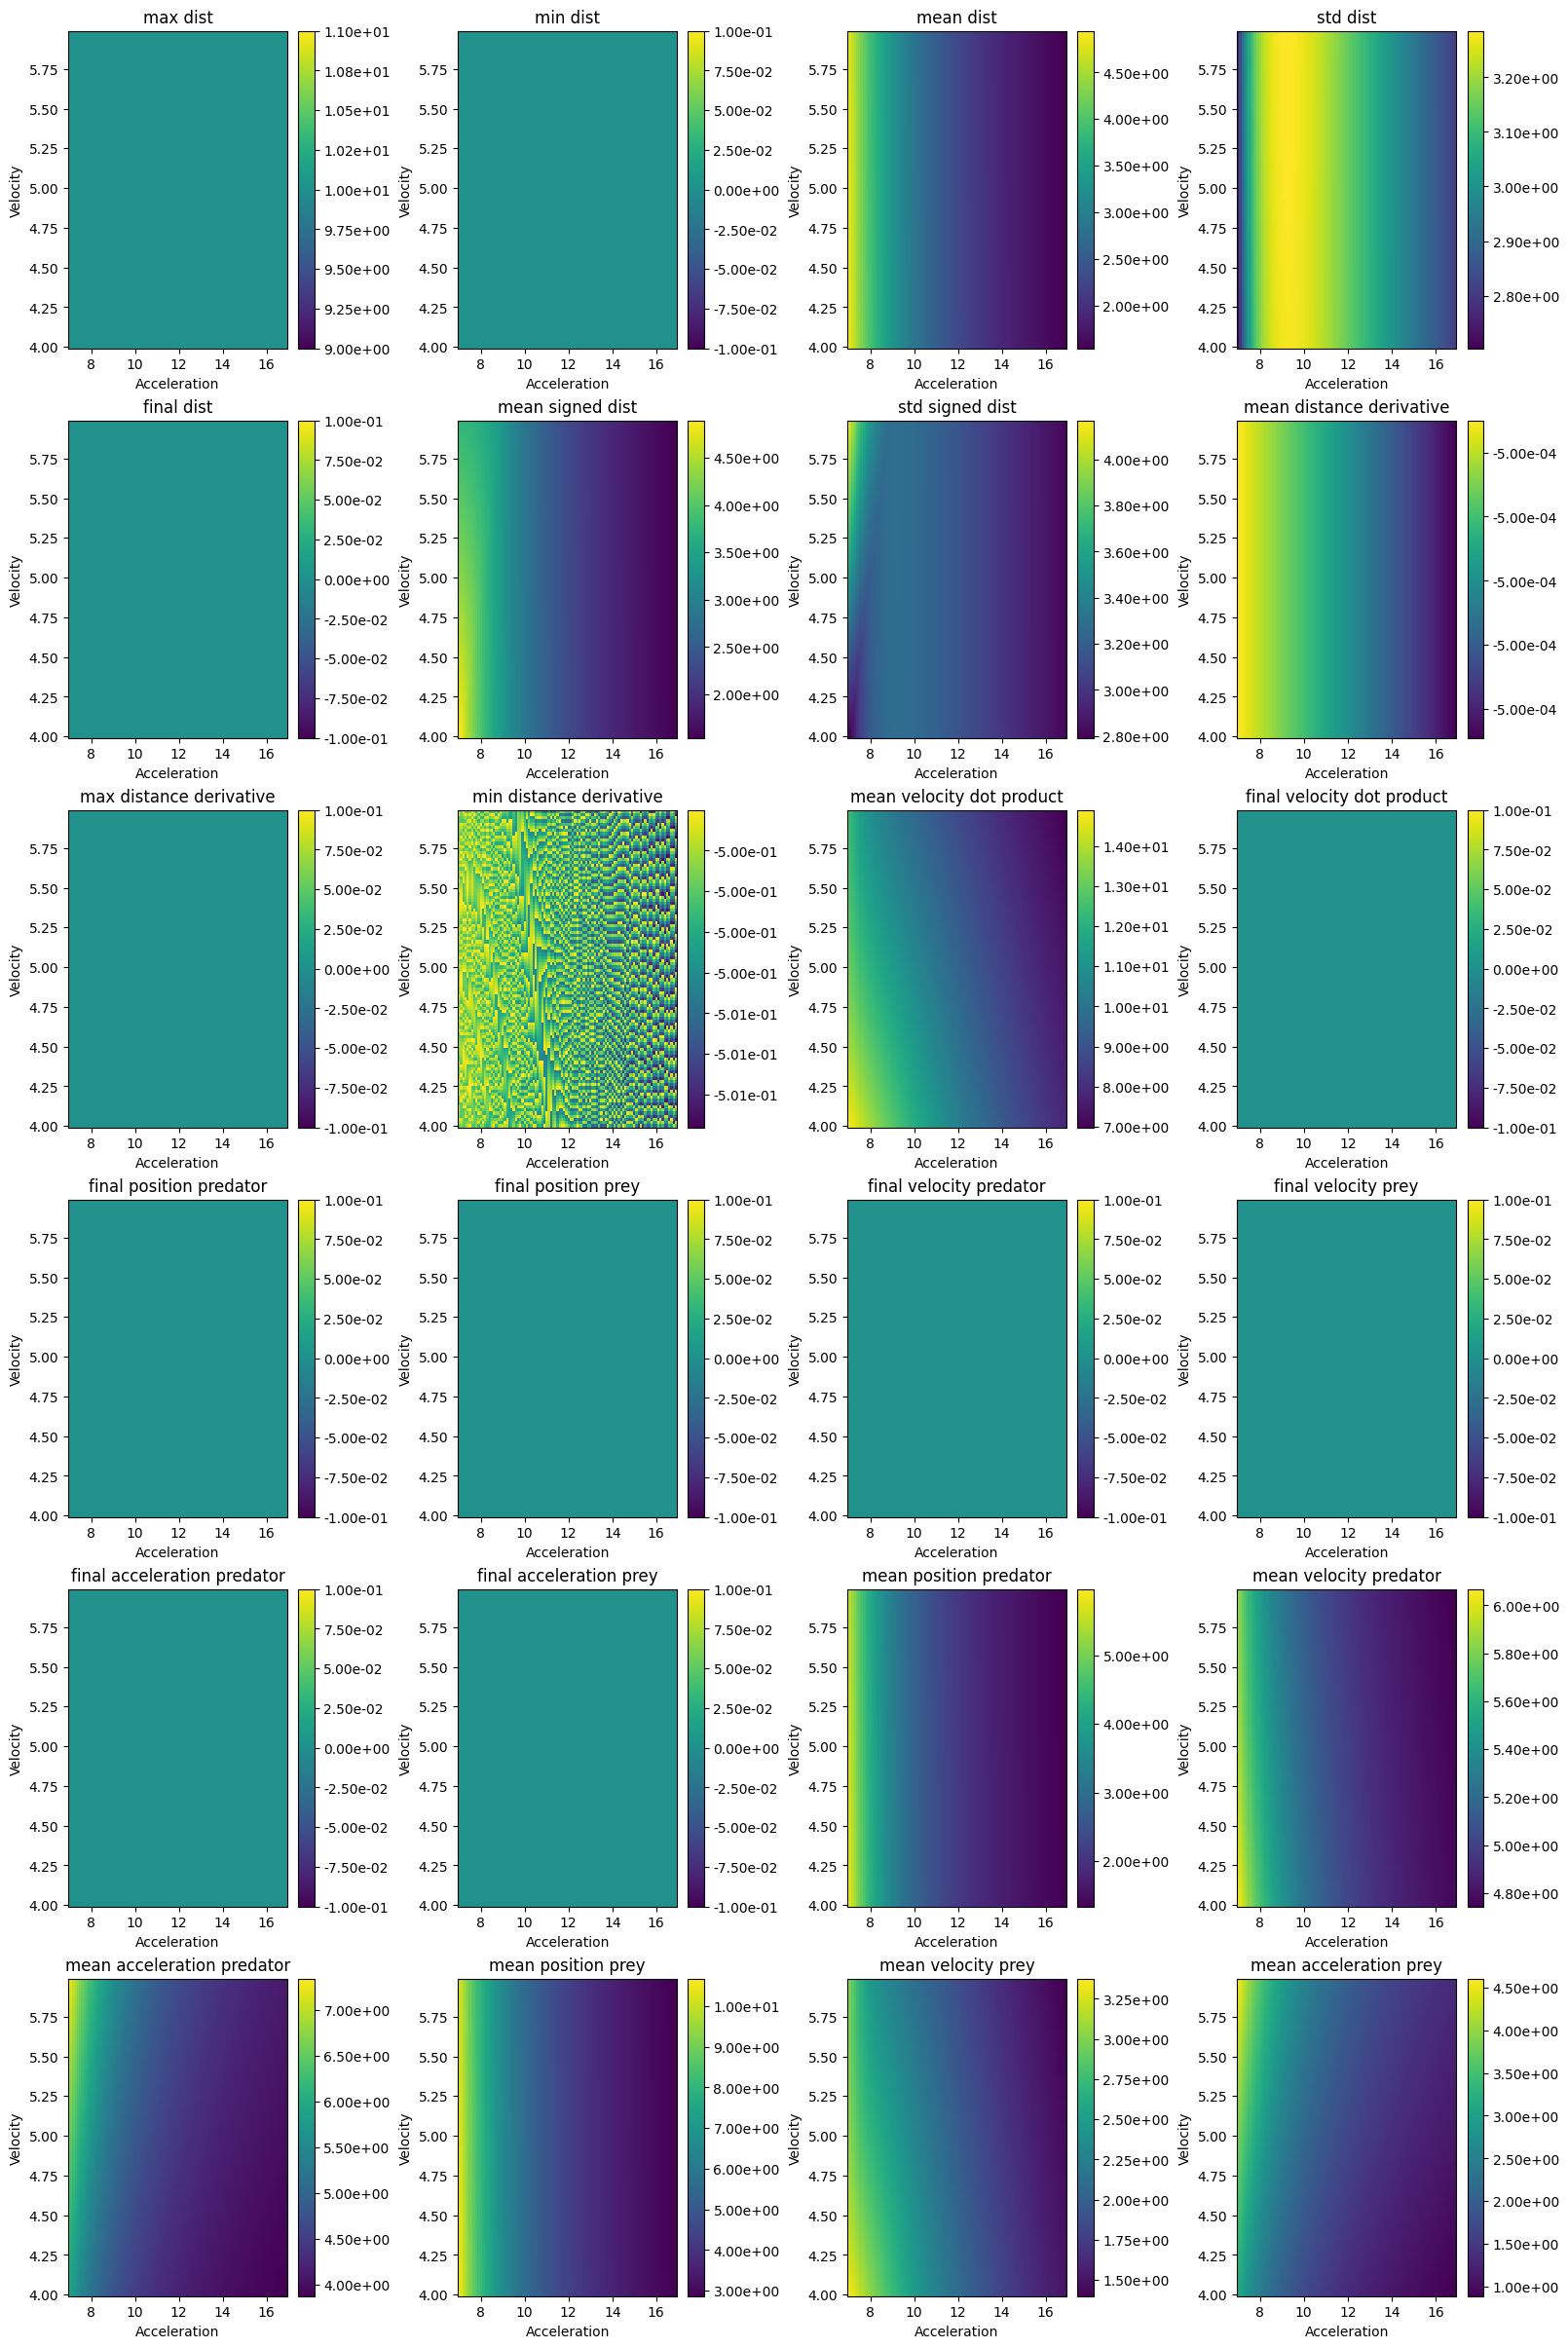

In [17]:
def plot_3d_array_slices(data: np.ndarray, params: dict, titles: list, xtitle: str, ytitle: str, x=None, y=None):
    """
    Plot slices of a (N, M, L) array as NxM images for each L, arranged in a 4x4 grid.
    """
    if x is None:
        x = np.arange(data.shape[0])
    if y is None:
        y = np.arange(data.shape[1])

    X, Y = np.meshgrid(y, x)

    n_slices = data.shape[2]
    ncols = 4
    nrows = int(np.ceil(n_slices / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

    for i in range(n_slices):
        row, col = divmod(i, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        pcm = ax.pcolormesh(Y, X, data[:, :, i], shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=ax, format=ticker.FuncFormatter(lambda x, _: f'{x:.2e}'))  # scientific notation
        ax.set_title(f'{titles[i]}')
        ax.set_xlabel(ytitle)
        ax.set_ylabel(xtitle)

    # Hide any unused subplots
    for j in range(n_slices, nrows * ncols):
        row, col = divmod(j, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        ax.axis('off')

    plt.show()
    
        
plot_3d_array_slices(result_grid, parameters, 
                     titles = get_phase_titles(),   
                     xtitle='Velocity',
                     x=v_range, 
                     ytitle='Acceleration',
                     y=a_range)

In [18]:
def parameter_string(v_range, a_range, parameters):
    def summarize_array(arr, name):
        return f"{name}[{arr[0]:.2f}-{arr[-1]:.2f}_{arr[1]-arr[0]:.2f}]"

    parts = [
        summarize_array(v_range, "v"),
        summarize_array(a_range, "a"),
        f"bearing{parameters['bearing']}",
        f"dt{parameters['dt']:.4f}",
        f"acc{parameters['pred_acc']}",
        f"r{parameters['r_react']}",
        f"preyVmax{parameters['prey_max_speed']}",
        f"d{parameters['distance']}"
    ]
    
    return "_".join(parts)

n_v, n_a = result_grid.shape[:2]

flat_data = result_grid.reshape(-1, 24)
v_idx = np.repeat(np.arange(n_v), n_a)
a_idx = np.tile(np.arange(n_a), n_v)

df = pd.DataFrame(flat_data, columns=get_phase_titles())
df["v_idx"] = v_idx
df["a_idx"] = a_idx
df.set_index(["v_idx", "a_idx"], inplace=True)
df.to_csv(parameter_string(v_range, a_range, parameters) + ".csv")
df.head()

max dist  min dist  mean dist  std dist  final dist  \
v_idx a_idx                                                        
0     0          10.0       0.0   4.947107  2.703588         0.0   
      1          10.0       0.0   4.945931  2.704643         0.0   
      2          10.0       0.0   4.944763  2.705691         0.0   
      3          10.0       0.0   4.943553  2.706813         0.0   
      4          10.0       0.0   4.942402  2.707845         0.0   

             mean signed dist  std signed dist  mean distance derivative  \
v_idx a_idx                                                                
0     0              4.896096         2.794905                   -0.0005   
      1              4.886186         2.811141                   -0.0005   
      2              4.876188         2.827409                   -0.0005   
      3              4.866031         2.843818                   -0.0005   
      4              4.855746         2.860331                   -0.0005   

             max distance derivative  min distance derivative  ...  \
v_idx a_idx                                                    ...   
0     0                          0.0                -0.500201  ...   
      1                          0.0                -0.500098  ...   
      2                          0.0                -0.500008  ...   
      3                          0.0                -0.500148  ...   
      4                          0.0                -0.500086  ...   

             final velocity predator  final velocity prey  \
v_idx a_idx                                                 
0     0                          0.0                  0.0   
      1                          0.0                  0.0   
      2                          0.0                  0.0   
      3                          0.0                  0.0   
      4                          0.0                  0.0   

             final acceleration predator  final acceleration prey  \
v_idx a_idx                                                         
0     0                              0.0                      0.0   
      1                              0.0                      0.0   
      2                              0.0                      0.0   
      3                              0.0                      0.0   
      4                              0.0                      0.0   

             mean position predator  mean velocity predator  \
v_idx a_idx                                                   
0     0                    5.965537                6.067698   
      1                    5.960943                6.063781   
      2                    5.956349                6.059891   
      3                    5.951170                6.055777   
      4                    5.946580                6.051944   

             mean acceleration predator  mean position prey  \
v_idx a_idx                                                   
0     0                        5.898524           10.678003   
      1                        5.912193           10.672295   
      2                        5.925867           10.666597   
      3                        5.939212           10.660279   
      4                        5.952894           10.654600   

             mean velocity prey  mean acceleration prey  
v_idx a_idx                                              
0     0                3.375328                3.136600  
      1                3.366283                3.151278  
      2                3.357360                3.165946  
      3                3.348521                3.180401  
      4                3.339846                3.195048  

[5 rows x 24 columns]